In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

In [2]:
perps_v3_df = pl.read_parquet("perps_v3.parquet").with_columns([
    (pl.col('size_delta').abs() * pl.col('price')).alias('size_usd_abs'),
    (pl.col('size_delta') * pl.col('price')).alias('size_usd')
])

In [3]:
# first and last trade
start_date = perps_v3_df.sort(by='datetime', descending=False)[0]['datetime'].item().strftime('%A, %B %d, %Y %I:%M %p')
end_date = perps_v3_df.sort(by='datetime', descending=False)[-1]['datetime'].item().strftime('%A, %B %d, %Y %I:%M %p')

print(f'first trade was on {start_date}')
print(f'last trade was on {end_date}')

first trade was on Monday, October 02, 2023 05:13 PM
last trade was on Monday, October 23, 2023 11:05 PM


In [4]:
# unique trades
trade_count = perps_v3_df.filter(pl.col('liquidation') == False).shape[0]
liquidation_count = perps_v3_df.filter(pl.col('liquidation') == True).shape[0]

print(f'there were {trade_count} orders successfully filled')
print(f'there were {liquidation_count} liquidation events')

there were 2287 orders successfully filled
there were 441 liquidation events


In [5]:
# get the overlap between unique accuonts
unique_liq_accts = perps_v3_df.filter(pl.col('liquidation') == True)['accountId'].unique().to_list()
unique_orders_accts = perps_v3_df.filter(pl.col('liquidation') == False)['accountId'].unique().to_list()

print(f'{len(unique_liq_accts)} unique accounts liquidated')
print(f'{len(unique_orders_accts)} unique accounts traded')

84 unique accounts liquidated
131 unique accounts traded


### Trades and Liquidation Trading Activity

In [6]:
# Group by datetime, count occurrences, and pivot to create a stacked DataFrame
activity_counts = (perps_v3_df
    .with_columns([pl.col('datetime').dt.round('1d').dt.strftime('%m-%d')])
    .group_by(pl.col('datetime', 'liquidation')).agg([pl.count()])
    .sort(by='datetime', descending=False)
).to_pandas()

In [7]:
activity_counts.head(5)

,datetime,liquidation,count
0,10-03,True,14
1,10-03,False,329
2,10-04,False,386
3,10-04,True,115
4,10-05,False,263


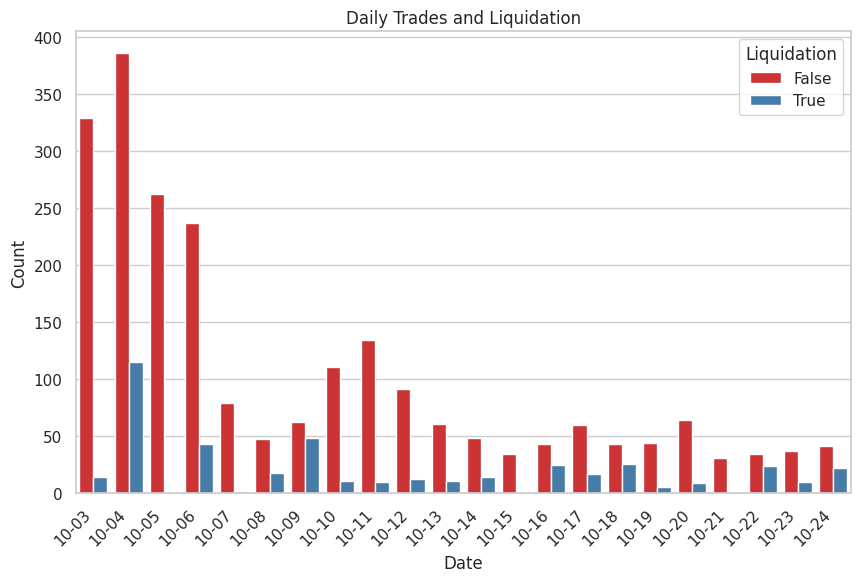

In [8]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.set(style="whitegrid")  # Set the style
sns.barplot(x="datetime", y="count", hue="liquidation", data=activity_counts, palette="Set1")

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Daily Trades and Liquidation")

plt.xticks(rotation=45, ha='right')

# Show the plot
plt.legend(title="Liquidation", loc="upper right")
plt.show()

### Per Market Basis

In [9]:
# Group by datetime, count occurrences, and pivot to create a stacked DataFrame
market_counts = (perps_v3_df
    .group_by(pl.col('marketSymbol', 'liquidation')).agg([pl.count()])
).to_pandas()

In [10]:
market_counts.head(5)

,marketSymbol,liquidation,count
0,SNX,True,105
1,OP,True,39
2,ETH,False,766
3,BTC,False,481
4,SNX,False,487


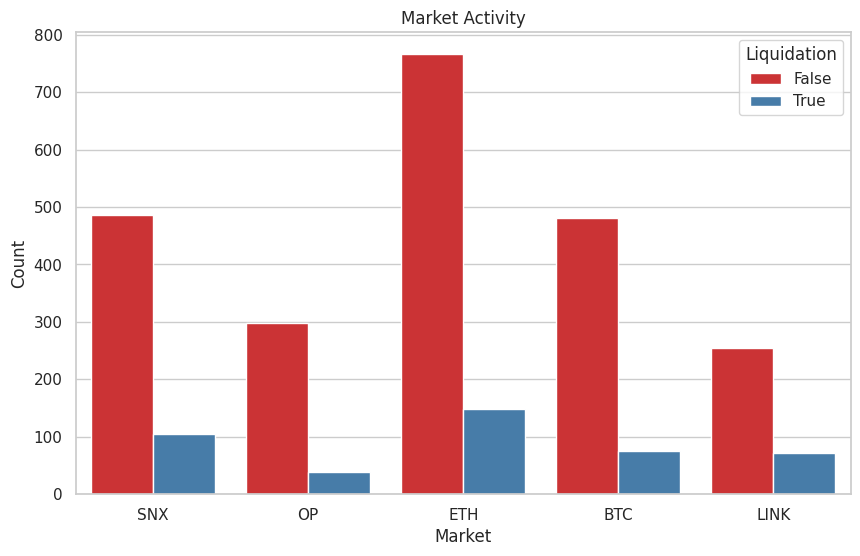

In [11]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.set(style="whitegrid")  # Set the style

g = sns.barplot(x="marketSymbol", y="count", hue="liquidation", data=market_counts, palette="Set1")

# Set labels and title
plt.xlabel("Market")
plt.ylabel("Count")
plt.title("Market Activity")

# Show the plot
plt.legend(title="Liquidation", loc="upper right")
plt.show()

### USD Values

In [12]:
perps_v3_df.head(5)

datetime,accountId,marketSymbol,size_delta,size,price,liquidation,size_usd_abs,size_usd
datetime[μs],str,str,f64,f64,f64,bool,f64,f64
2023-10-23 22:48:26,"""17014118346046…","""LINK""",1234.3639,0.0,10.533,true,0.0,0.0
2023-10-23 22:47:46,"""17014118346046…","""LINK""",19999.8,-1234.3639,10.526109,true,12993.048599,-12993.048599
2023-10-23 22:47:04,"""17014118346046…","""LINK""",19999.8,-21234.1639,10.56526,true,224344.472041,-224344.472041
2023-10-23 22:46:24,"""17014118346046…","""LINK""",19999.8,-41233.9639,10.528384,true,434127.009905,-434127.009905
2023-10-23 22:45:44,"""17014118346046…","""LINK""",19999.8,-61233.7639,10.632118,true,651044.617453,-651044.617453


In [13]:
# Group by datetime, count occurrences, and pivot to create a stacked DataFrame
volume_usd_abs = (perps_v3_df
    .with_columns([pl.col('datetime').dt.round('1d').dt.strftime('%m-%d')])
    .group_by(pl.col('datetime', 'liquidation')).agg([pl.sum('size_usd_abs')])
    .sort(by='datetime', descending=False)
).to_pandas()

In [14]:
volume_usd_abs.head(5)

,datetime,liquidation,size_usd_abs
0,10-03,True,0.000000e+00
1,10-03,False,1.584710e+08
2,10-04,False,3.994092e+08
3,10-04,True,1.077936e+09
4,10-05,False,3.052775e+08


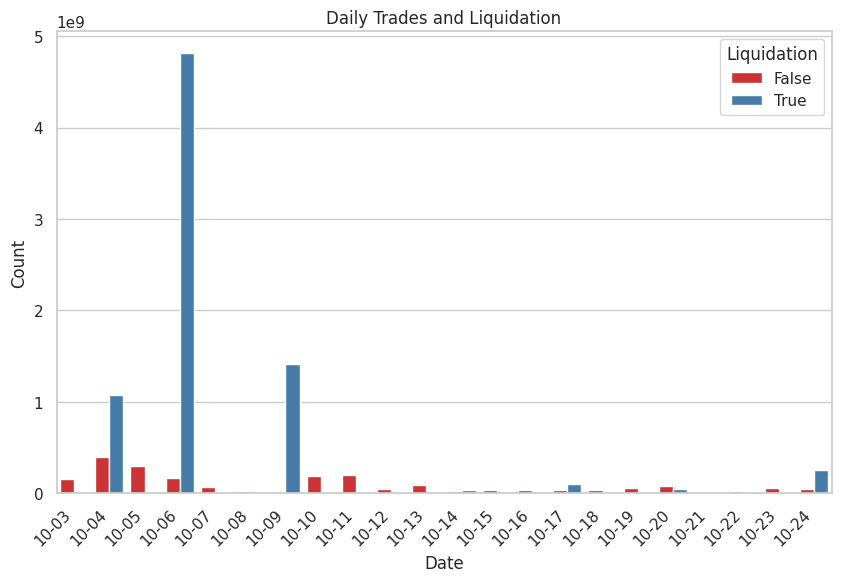

In [15]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.set(style="whitegrid")  # Set the style
sns.barplot(x="datetime", y="size_usd_abs", hue="liquidation", data=volume_usd_abs, palette="Set1")

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Daily Trades and Liquidation")

plt.xticks(rotation=45, ha='right')

# Show the plot
plt.legend(title="Liquidation", loc="upper right")
plt.show()